# xarray

还有一个数据处理的库非常好用 -- xarray。本文参考以下资料,简单记录下xarray的基本使用方法。

- [xarray官方文档](http://xarray.pydata.org/en/stable/)
- [Pangeo Tutorial Gallery / Xarray Tutorial](http://gallery.pangeo.io/repos/pangeo-data/pangeo-tutorial-gallery/xarray.html)

xarray是一个专门用来处理多维标签数据的python库。Xarray在类似于**NumPy的原始数组上以维度，坐标和属性的形式引入标签**，从而提供了更直观，更简洁和更少出错的开发人员体验。引入标签的原因是现实世界中，数据往往不是原始的多维数组，而还包含一系列反映数据编码信息的标签，比如时空信息。xarray可以利用这些标签更好地完成对数据的操作，后面会根据实际使用逐步记录。

Xarray借鉴了pandas，特别适合处理netCDF文件，netcdf是xarray数据模型的来源，如果不了解netcdf可以参考：[netcdf-python 介绍](https://github.com/OuyangWenyu/aqualord/blob/master/DataFormat/netcdf.ipynb)。xarray中最基本的数据结构是DataArray和Dataset，前者类似于pandas里的Series，后者类似DataFrame，更多信息后面记录。

例如，下图显示了一个“数据立方体”数据，其中温度和降水共享相同的三个维度，以及作为辅助坐标的经度和纬度。

![](pictures/dataset-diagram.png)

另外xarray还与dask紧密集成以进行并行计算，后面用到dask再做记录。

conda安装（本repo environment.yml文件已包括）：

```Shell
conda install -c conda-forge xarray
```

## 基本术语

以下无明确说明时，arr 表示DataArray对象。

- DataArray：是一个多维数组，有标签，如果name属性设置了，就成为一个named DataArray
- Dataset：一个类dict的DataArray对象集合，有多个排列的维度。Datasets有 Varaible
- Varaible：类似于netcdf的variable，包含维度，数据，属性等。variables和numpy数组的主要区别是变量上的广播运算基于维度名称的。每个DataArray有一个潜在variable可以通过arr.variable访问。Variable在Dataset和DataArray内的，所以不必单独用它。
- Dimension：一个维度轴就是固定一个维度上的所有点的集合。每个维度轴有一个名字，比如x维度。DataArray对象的维度就是被命名的维度轴。第i个维度名称可用arr.dim[i]获取。默认的维度名称是dim_0,dim_1以此类推。
- Coordinate：一个标记维度的数组。在一维情况下，坐标数组的至可以被认为是维度的标签。有两种坐标：
    - Dimension coordinate：一维的坐标数组用名字和维度名字指定给arr，可见于arr.dims。维度坐标类似于DataFrame中的index。
    - Non-dimension coordinate：非维度坐标可见于arr.coords，这些坐标数组可以是一维也可以是多维，多维情况主要见于物理坐标和逻辑坐标不一致的时候，非维度坐标是不能索引的。
- Index：index是优化数据结构用于快速索引和切片的。xarray用维度坐标可以i快速索引。

以上有些晦涩，接下来看例子。

## 基本数据结构

先看DataArray，多维标记数组。

### DataArray

In [1]:
import numpy as np
data = np.random.rand(4, 3)
data

array([[0.99800627, 0.10697747, 0.53674625],
       [0.2134859 , 0.17025178, 0.42545607],
       [0.34115689, 0.05752575, 0.86193741],
       [0.73160757, 0.91303752, 0.2315763 ]])

In [2]:
import pandas as pd
locs = ['IA', 'IL', 'IN']
times = pd.date_range('2000-01-01', periods=4)
times

DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04'], dtype='datetime64[ns]', freq='D')

In [3]:
import xarray as xr
foo = xr.DataArray(data, coords=[times, locs], dims=['time', 'space'])
foo

<xarray.DataArray (time: 4, space: 3)>
array([[0.99800627, 0.10697747, 0.53674625],
       [0.2134859 , 0.17025178, 0.42545607],
       [0.34115689, 0.05752575, 0.86193741],
       [0.73160757, 0.91303752, 0.2315763 ]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
  * space    (space) <U2 'IA' 'IL' 'IN'

可以看到这个arr有两个坐标，一个时间，一个空间，时间对应一个坐标数组，是pandas的data_range，空间对应一个list，相应的数据有4 * 3=12个，且数组共4行，对应4个时间，三列对应三个空间。

最简单的初始化方式是直接使用data'：

In [4]:
xr.DataArray(data)

<xarray.DataArray (dim_0: 4, dim_1: 3)>
array([[0.99800627, 0.10697747, 0.53674625],
       [0.2134859 , 0.17025178, 0.42545607],
       [0.34115689, 0.05752575, 0.86193741],
       [0.73160757, 0.91303752, 0.2315763 ]])
Dimensions without coordinates: dim_0, dim_1

可以看到默认的坐标。

另外，可以直接使用字典形式创建coords：

In [5]:
xr.DataArray(data, coords=[('time', times), ('space', locs)])

<xarray.DataArray (time: 4, space: 3)>
array([[0.99800627, 0.10697747, 0.53674625],
       [0.2134859 , 0.17025178, 0.42545607],
       [0.34115689, 0.05752575, 0.86193741],
       [0.73160757, 0.91303752, 0.2315763 ]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
  * space    (space) <U2 'IA' 'IL' 'IN'

再比如多维的：

In [6]:
xr.DataArray(data, coords={'time': times, 'space': locs, 'const': 42, 
                           'ranking': (('time', 'space'), np.arange(12).reshape(4,3))},
             dims=['time', 'space'])

<xarray.DataArray (time: 4, space: 3)>
array([[0.99800627, 0.10697747, 0.53674625],
       [0.2134859 , 0.17025178, 0.42545607],
       [0.34115689, 0.05752575, 0.86193741],
       [0.73160757, 0.91303752, 0.2315763 ]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
  * space    (space) <U2 'IA' 'IL' 'IN'
    const    int32 42
    ranking  (time, space) int32 0 1 2 3 4 5 6 7 8 9 10 11

如上，time和space是维度坐标，const和ranking就是非维度坐标。维度是直接和数据对应上的，其他非维度的坐标是其他和数据不直接对应的。

另外，还可以使用DataFrame来初始化：

In [7]:
df = pd.DataFrame({'x': [0, 1], 'y': [2, 3]}, index=['a', 'b'])
df

,x,y
a,0,2
b,1,3


In [8]:
df.index.name = 'abc'
df

,x,y
abc,,
a,0,2
b,1,3


In [9]:
df.columns.name = 'xyz'
df

xyz,x,y
abc,,
a,0,2
b,1,3


In [10]:
xr.DataArray(df)

<xarray.DataArray (abc: 2, xyz: 2)>
array([[0, 2],
       [1, 3]], dtype=int64)
Coordinates:
  * abc      (abc) object 'a' 'b'
  * xyz      (xyz) object 'x' 'y'

接下来看看数组的属性：

In [11]:
foo.values

array([[0.99800627, 0.10697747, 0.53674625],
       [0.2134859 , 0.17025178, 0.42545607],
       [0.34115689, 0.05752575, 0.86193741],
       [0.73160757, 0.91303752, 0.2315763 ]])

注意DataArray中的数组值都是统一的数据类型。如果需要不同数据类型的，那么需要使用Dataset。

In [12]:
foo.dims

('time', 'space')

In [13]:
foo.coords

Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
  * space    (space) <U2 'IA' 'IL' 'IN'

In [14]:
foo.attrs

{}

In [15]:
print(foo.name)

None


以上有缺失默认值的，可以使用下列方式补充：

In [16]:
foo.name = 'foo'
foo.attrs['units'] = 'meters'
foo

<xarray.DataArray 'foo' (time: 4, space: 3)>
array([[0.99800627, 0.10697747, 0.53674625],
       [0.2134859 , 0.17025178, 0.42545607],
       [0.34115689, 0.05752575, 0.86193741],
       [0.73160757, 0.91303752, 0.2315763 ]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
  * space    (space) <U2 'IA' 'IL' 'IN'
Attributes:
    units:    meters

使用rename会返回一个新的数据数组：

In [17]:
foo.rename('bar')

<xarray.DataArray 'bar' (time: 4, space: 3)>
array([[0.99800627, 0.10697747, 0.53674625],
       [0.2134859 , 0.17025178, 0.42545607],
       [0.34115689, 0.05752575, 0.86193741],
       [0.73160757, 0.91303752, 0.2315763 ]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
  * space    (space) <U2 'IA' 'IL' 'IN'
Attributes:
    units:    meters

坐标是类似dict类型的

In [18]:
foo.coords['time']

<xarray.DataArray 'time' (time: 4)>
array(['2000-01-01T00:00:00.000000000', '2000-01-02T00:00:00.000000000',
       '2000-01-03T00:00:00.000000000', '2000-01-04T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04

In [19]:
foo['time']

<xarray.DataArray 'time' (time: 4)>
array(['2000-01-01T00:00:00.000000000', '2000-01-02T00:00:00.000000000',
       '2000-01-03T00:00:00.000000000', '2000-01-04T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04

坐标可以被删除：

In [20]:
foo['ranking'] = ('space', [1, 2, 3])
foo.coords

Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
  * space    (space) <U2 'IA' 'IL' 'IN'
    ranking  (space) int32 1 2 3

In [21]:
del foo['ranking']
foo.coords

Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
  * space    (space) <U2 'IA' 'IL' 'IN'

稍微小结下 DataArray：首先主体还是一个数组，数组的坐标直接对应维度坐标，比如一个二维的数组，那么就有两个维度坐标，数组中每个数据都唯一对应一对维度坐标值；还可以有非维度坐标，另外还有描述DataArray属性的。

下面看Dataset，它就是为netcdf定制的。可以简单地认为 Dataset 就是多个具有相同坐标系的 DataArray 的组合体。

### Dataset

In [22]:
temp = 15 + 8 * np.random.randn(2, 2, 3)
temp

array([[[23.18618225, 16.62877253, 20.2934517 ],
        [12.64546683,  7.9220311 , 16.94113908]],

       [[ 3.2112235 ,  5.29999304, 10.02171398],
        [13.48221583,  0.94690607, 18.03473387]]])

In [23]:
precip = 10 * np.random.rand(2, 2, 3)
precip 

array([[[6.16307358, 9.75041979, 3.83807332],
        [8.3555005 , 4.40372056, 1.91066065]],

       [[2.10114698, 6.13556892, 9.58585718],
        [1.98922117, 1.39673257, 4.39125251]]])

In [24]:
lon = [[-99.83, -99.32], [-99.79, -99.23]]
lat = [[42.25, 42.21], [42.63, 42.59]]
ds = xr.Dataset({'temperature': (['x', 'y', 'time'],  temp),
                     'precipitation': (['x', 'y', 'time'], precip)},
                    coords={'lon': (['x', 'y'], lon),
                            'lat': (['x', 'y'], lat),
                            'time': pd.date_range('2014-09-06', periods=3),
                            'reference_time': pd.Timestamp('2014-09-05')})
ds

<xarray.Dataset>
Dimensions:         (time: 3, x: 2, y: 2)
Coordinates:
    lon             (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat             (x, y) float64 42.25 42.21 42.63 42.59
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
    reference_time  datetime64[ns] 2014-09-05
Dimensions without coordinates: x, y
Data variables:
    temperature     (x, y, time) float64 23.19 16.63 20.29 ... 0.9469 18.03
    precipitation   (x, y, time) float64 6.163 9.75 3.838 ... 1.989 1.397 4.391

可以直接传入DataArray到Dataset，或者DataFrame。

In [25]:
xr.Dataset({'bar': foo})

<xarray.Dataset>
Dimensions:  (space: 3, time: 4)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
  * space    (space) <U2 'IA' 'IL' 'IN'
Data variables:
    bar      (time, space) float64 0.998 0.107 0.5367 ... 0.7316 0.913 0.2316

In [34]:
type(foo.to_pandas())

pandas.core.frame.DataFrame

In [26]:
xr.Dataset({'bar': foo.to_pandas()})

<xarray.Dataset>
Dimensions:  (space: 3, time: 4)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
  * space    (space) object 'IA' 'IL' 'IN'
Data variables:
    bar      (time, space) float64 0.998 0.107 0.5367 ... 0.7316 0.913 0.2316

variable 就是 组成 Dataset 的 DataArray 的名字，也就是上面初始化时候 用的 dict 的 key。

像dict中使用key那样在Dataset中使用 variable 即可取出 DataArray：

In [27]:
'temperature' in ds

True

In [28]:
ds['temperature']

<xarray.DataArray 'temperature' (x: 2, y: 2, time: 3)>
array([[[23.18618225, 16.62877253, 20.2934517 ],
        [12.64546683,  7.9220311 , 16.94113908]],

       [[ 3.2112235 ,  5.29999304, 10.02171398],
        [13.48221583,  0.94690607, 18.03473387]]])
Coordinates:
    lon             (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat             (x, y) float64 42.25 42.21 42.63 42.59
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
    reference_time  datetime64[ns] 2014-09-05
Dimensions without coordinates: x, y

或者：

In [33]:
ds.temperature

<xarray.DataArray 'temperature' (x: 2, y: 2, time: 3)>
array([[[23.18618225, 16.62877253, 20.2934517 ],
        [12.64546683,  7.9220311 , 16.94113908]],

       [[ 3.2112235 ,  5.29999304, 10.02171398],
        [13.48221583,  0.94690607, 18.03473387]]])
Coordinates:
    lon             (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat             (x, y) float64 42.25 42.21 42.63 42.59
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
    reference_time  datetime64[ns] 2014-09-05
Dimensions without coordinates: x, y

Dataset的变量：

In [29]:
ds.data_vars

Data variables:
    temperature    (x, y, time) float64 23.19 16.63 20.29 ... 13.48 0.9469 18.03
    precipitation  (x, y, time) float64 6.163 9.75 3.838 ... 1.989 1.397 4.391

Dataset的坐标：

In [30]:
ds.coords

Coordinates:
    lon             (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat             (x, y) float64 42.25 42.21 42.63 42.59
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
    reference_time  datetime64[ns] 2014-09-05

Dataset的属性：

In [31]:
ds.attrs

{}

In [32]:
ds.attrs['title'] = 'example attribute'
ds

<xarray.Dataset>
Dimensions:         (time: 3, x: 2, y: 2)
Coordinates:
    lon             (x, y) float64 -99.83 -99.32 -99.79 -99.23
    lat             (x, y) float64 42.25 42.21 42.63 42.59
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
    reference_time  datetime64[ns] 2014-09-05
Dimensions without coordinates: x, y
Data variables:
    temperature     (x, y, time) float64 23.19 16.63 20.29 ... 0.9469 18.03
    precipitation   (x, y, time) float64 6.163 9.75 3.838 ... 1.989 1.397 4.391
Attributes:
    title:    example attribute

Dataset的长度是指的是变量的个数。

In [37]:
len(ds)

2

如果想要保存 Dataset，最自然的方法自然是保存到 netcdf 文件。

In [39]:
ds.to_netcdf("saved_on_disk.nc")

在xarray中读取netcdf文件可以这样：

In [40]:
ds_disk = xr.open_dataset("saved_on_disk.nc")
ds_disk

<xarray.Dataset>
Dimensions:         (time: 3, x: 2, y: 2)
Coordinates:
  * time            (time) datetime64[ns] 2014-09-06 2014-09-07 2014-09-08
    lon             (x, y) float64 ...
    lat             (x, y) float64 ...
    reference_time  datetime64[ns] ...
Dimensions without coordinates: x, y
Data variables:
    temperature     (x, y, time) float64 ...
    precipitation   (x, y, time) float64 ...
Attributes:
    title:    example attribute

## 简单运算示例

xarray的DataArray计算和numpy的array计算是一致的,所以至少形式上,两者可以保持一致,这对python编程也是很有利的.

下面是具体的例子.

In [1]:
import numpy as np
import xarray as xr

现在构建 f(x)=sin(x)

In [2]:
x = np.linspace(-np.pi, np.pi, 19)
f = np.sin(x)

把数据放入DataArray

In [3]:
da_f = xr.DataArray(f)
da_f

<xarray.DataArray (dim_0: 19)>
array([-1.22464680e-16, -3.42020143e-01, -6.42787610e-01, -8.66025404e-01,
       -9.84807753e-01, -9.84807753e-01, -8.66025404e-01, -6.42787610e-01,
       -3.42020143e-01,  0.00000000e+00,  3.42020143e-01,  6.42787610e-01,
        8.66025404e-01,  9.84807753e-01,  9.84807753e-01,  8.66025404e-01,
        6.42787610e-01,  3.42020143e-01,  1.22464680e-16])
Dimensions without coordinates: dim_0

完善数据的信息

In [4]:
da_f = xr.DataArray(f, dims=['x'])
da_f

<xarray.DataArray (x: 19)>
array([-1.22464680e-16, -3.42020143e-01, -6.42787610e-01, -8.66025404e-01,
       -9.84807753e-01, -9.84807753e-01, -8.66025404e-01, -6.42787610e-01,
       -3.42020143e-01,  0.00000000e+00,  3.42020143e-01,  6.42787610e-01,
        8.66025404e-01,  9.84807753e-01,  9.84807753e-01,  8.66025404e-01,
        6.42787610e-01,  3.42020143e-01,  1.22464680e-16])
Dimensions without coordinates: x

In [5]:
da_f = xr.DataArray(f, dims=['x'], coords={'x': x})
da_f

<xarray.DataArray (x: 19)>
array([-1.22464680e-16, -3.42020143e-01, -6.42787610e-01, -8.66025404e-01,
       -9.84807753e-01, -9.84807753e-01, -8.66025404e-01, -6.42787610e-01,
       -3.42020143e-01,  0.00000000e+00,  3.42020143e-01,  6.42787610e-01,
        8.66025404e-01,  9.84807753e-01,  9.84807753e-01,  8.66025404e-01,
        6.42787610e-01,  3.42020143e-01,  1.22464680e-16])
Coordinates:
  * x        (x) float64 -3.142 -2.793 -2.443 -2.094 ... 2.094 2.443 2.793 3.142

xarray还有像pandas那样的方便绘图功能.

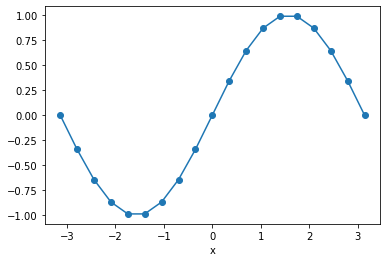

In [6]:
da_f.plot(marker='o')

### 索引数据

和numpy中的indexing和slicing一致

In [7]:
# get the 10th item
da_f[10]

<xarray.DataArray ()>
array(0.34202014)
Coordinates:
    x        float64 0.3491

In [8]:
# get the first 10 items
da_f[:10]

<xarray.DataArray (x: 10)>
array([-1.22464680e-16, -3.42020143e-01, -6.42787610e-01, -8.66025404e-01,
       -9.84807753e-01, -9.84807753e-01, -8.66025404e-01, -6.42787610e-01,
       -3.42020143e-01,  0.00000000e+00])
Coordinates:
  * x        (x) float64 -3.142 -2.793 -2.443 -2.094 ... -0.6981 -0.3491 0.0

不过在xarray中更强大的是 .sel() 函数,来进行带标签的索引,这样能根据坐标来索引

In [9]:
da_f.sel(x=0)

<xarray.DataArray ()>
array(0.)
Coordinates:
    x        float64 0.0

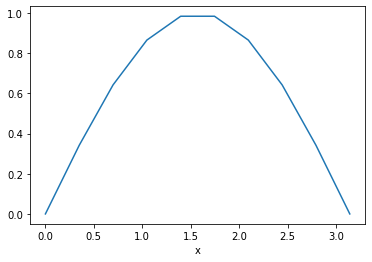

In [10]:
da_f.sel(x=slice(0, np.pi)).plot()

### 基本运算

当对xarray DataArrays进行数学运算时，坐标随之而来。假设我们要计算: $g=f^2+1$,那么可以像在numpy中运算一样:

In [11]:
da_g = da_f**2 + 1
da_g

<xarray.DataArray (x: 19)>
array([1.        , 1.11697778, 1.41317591, 1.75      , 1.96984631,
       1.96984631, 1.75      , 1.41317591, 1.11697778, 1.        ,
       1.11697778, 1.41317591, 1.75      , 1.96984631, 1.96984631,
       1.75      , 1.41317591, 1.11697778, 1.        ])
Coordinates:
  * x        (x) float64 -3.142 -2.793 -2.443 -2.094 ... 2.094 2.443 2.793 3.142

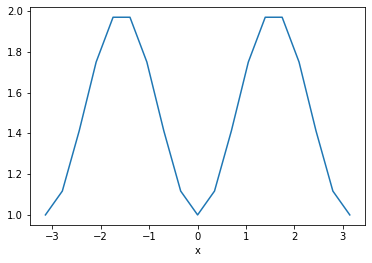

In [12]:
da_g.plot()

### 处理多维数据

相比于单维数据和numpy,pandas类似的能力,xarray在处理多维数据方面有更多的优势.

手动下载下数据, 在本文件夹下执行:

```Shell
git clone https://github.com/pangeo-data/tutorial-data.git
```

读取示例netcdf文件数据:

In [2]:
import xarray as xr
ds = xr.open_dataset('./tutorial-data/sst/NOAA_NCDC_ERSST_v3b_SST-1960.nc')
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 12)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 1960-12-15
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

In [3]:
# both do the exact same thing

# dictionary syntax
sst = ds['sst']

# attribute syntax
sst = ds.sst

sst

<xarray.DataArray 'sst' (time: 12, lat: 89, lon: 180)>
[192240 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 1960-12-15
Attributes:
    pointwidth:          1.0
    valid_min:           -3.0
    valid_max:           45.0
    units:               degree_Celsius
    long_name:           Extended reconstructed sea surface temperature
    standard_name:       sea_surface_temperature
    iridl:hasSemantics:  iridl:SeaSurfaceTemperature

下面是多维索引,选择特定日期的数据

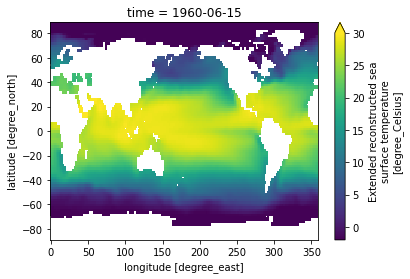

In [7]:
sst.sel(time='1960-06-15').plot(vmin=-2, vmax=30)

还可以沿任何axis选择值:

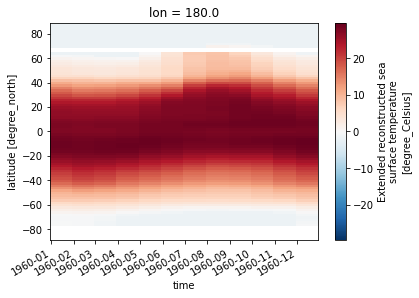

In [8]:
sst.sel(lon=180).transpose().plot()

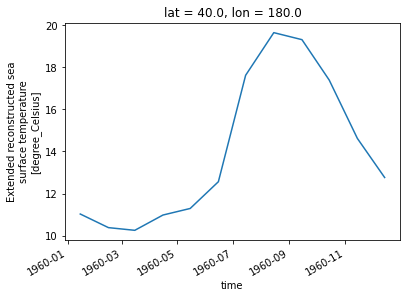

In [8]:
sst.sel(lon=180, lat=40).plot()

下面是一些数据分析的例子,对数据做"减法",统计如均值,标准差,最值的信息.

比如,针对所有维度:

In [9]:
sst.mean()

<xarray.DataArray 'sst' ()>
array(13.626506, dtype=float32)

In [9]:
# 对float数据, 默认是skip nan值的
sst.mean(skipna=True)

<xarray.DataArray 'sst' ()>
array(13.626506, dtype=float32)

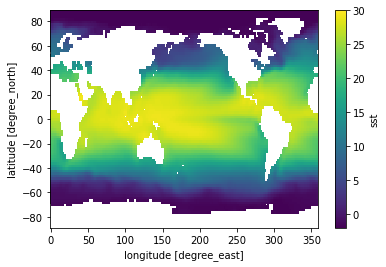

In [10]:
sst_time_mean = sst.mean(dim='time')
sst_time_mean.plot(vmin=-2, vmax=30)

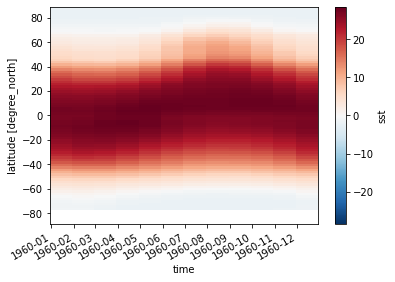

In [11]:
sst_zonal_mean = sst.mean(dim='lon')
sst_zonal_mean.transpose().plot()

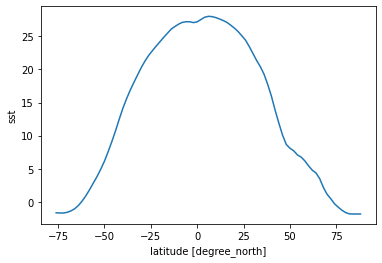

In [12]:
sst_time_and_zonal_mean = sst.mean(dim=('time', 'lon'))
sst_time_and_zonal_mean.plot()

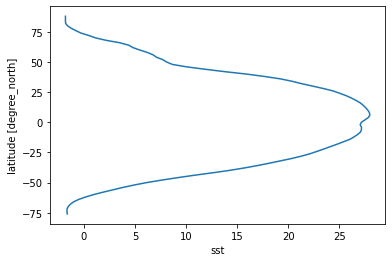

In [13]:
# some might prefer to have lat on the y axis
sst_time_and_zonal_mean.plot(y='lat')

下面是一个更复杂的例子,计算加权平均温度. 因为球面上每个微元的面积并不一样, 所以需要计算出来然后面积加权.

计算球面上一个微元的面积:

$$\delta A = R^2 \delta\phi \delta\lambda cos(\phi)$$

其中,$\phi$是维度,$\lambda$是经度,单位都是弧度. R是地球半径.

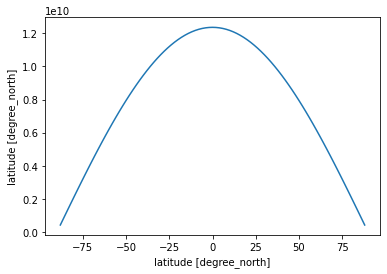

In [15]:
import numpy as np
R = 6.37e6
# we know already that the spacing of the points is one degree latitude
dϕ = np.deg2rad(1.)
dλ = np.deg2rad(1.)
dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(ds.lat))
dA.plot()

其中,ds.lat 是将维度取出来, 维度是坐标,所以取出来数据是一维的, 也是DataArray

In [16]:
ds.lat

<xarray.DataArray 'lat' (lat: 89)>
array([-88., -86., -84., -82., -80., -78., -76., -74., -72., -70., -68., -66.,
       -64., -62., -60., -58., -56., -54., -52., -50., -48., -46., -44., -42.,
       -40., -38., -36., -34., -32., -30., -28., -26., -24., -22., -20., -18.,
       -16., -14., -12., -10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,
         8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,  24.,  26.,  28.,  30.,
        32.,  34.,  36.,  38.,  40.,  42.,  44.,  46.,  48.,  50.,  52.,  54.,
        56.,  58.,  60.,  62.,  64.,  66.,  68.,  70.,  72.,  74.,  76.,  78.,
        80.,  82.,  84.,  86.,  88.], dtype=float32)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
Attributes:
    standard_name:  latitude
    pointwidth:     2.0
    gridtype:       0
    units:          degree_north

对应的dA也是相同结构

In [17]:
dA

<xarray.DataArray 'lat' (lat: 89)>
array([4.3137280e+08, 8.6222048e+08, 1.2920163e+09, 1.7202395e+09,
       2.1463668e+09, 2.5698775e+09, 2.9902589e+09, 3.4069967e+09,
       3.8195827e+09, 4.2275164e+09, 4.6302991e+09, 5.0274396e+09,
       5.4184561e+09, 5.8028713e+09, 6.1802148e+09, 6.5500303e+09,
       6.9118648e+09, 7.2652795e+09, 7.6098412e+09, 7.9451320e+09,
       8.2707420e+09, 8.5862769e+09, 8.8913500e+09, 9.1855903e+09,
       9.4686392e+09, 9.7401528e+09, 9.9997983e+09, 1.0247262e+10,
       1.0482239e+10, 1.0704446e+10, 1.0913612e+10, 1.1109481e+10,
       1.1291815e+10, 1.1460392e+10, 1.1615006e+10, 1.1755469e+10,
       1.1881608e+10, 1.1993273e+10, 1.2090326e+10, 1.2172647e+10,
       1.2240139e+10, 1.2292720e+10, 1.2330322e+10, 1.2352901e+10,
       1.2360431e+10, 1.2352901e+10, 1.2330322e+10, 1.2292720e+10,
       1.2240139e+10, 1.2172647e+10, 1.2090326e+10, 1.1993273e+10,
       1.1881608e+10, 1.1755469e+10, 1.1615006e+10, 1.1460392e+10,
       1.1291815e+10, 1.1109481e+10, 1.0913612e+10, 1.0704446e+10,
       1.0482239e+10, 1.0247262e+10, 9.9997983e+09, 9.7401528e+09,
       9.4686392e+09, 9.1855903e+09, 8.8913500e+09, 8.5862769e+09,
       8.2707420e+09, 7.9451320e+09, 7.6098412e+09, 7.2652795e+09,
       6.9118648e+09, 6.5500303e+09, 6.1802148e+09, 5.8028713e+09,
       5.4184561e+09, 5.0274396e+09, 4.6302991e+09, 4.2275164e+09,
       3.8195827e+09, 3.4069967e+09, 2.9902589e+09, 2.5698775e+09,
       2.1463668e+09, 1.7202395e+09, 1.2920163e+09, 8.6222048e+08,
       4.3137280e+08], dtype=float32)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
Attributes:
    standard_name:  latitude
    pointwidth:     2.0
    gridtype:       0
    units:          degree_north

可以将数据扩充到lat和lon作为坐标的DataArray上, 利用where函数即可, where函数不仅可以判断索引, 还具备广播能力

In [18]:
dA.where(sst[0].notnull())

<xarray.DataArray 'lat' (lat: 89, lon: 180)>
array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       ...,
       [1.2920163e+09, 1.2920163e+09, 1.2920163e+09, ..., 1.2920163e+09,
        1.2920163e+09, 1.2920163e+09],
       [8.6222048e+08, 8.6222048e+08, 8.6222048e+08, ..., 8.6222048e+08,
        8.6222048e+08, 8.6222048e+08],
       [4.3137280e+08, 4.3137280e+08, 4.3137280e+08, ..., 4.3137280e+08,
        4.3137280e+08, 4.3137280e+08]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
    time     datetime64[ns] 1960-01-15
Attributes:
    standard_name:  latitude
    pointwidth:     2.0
    gridtype:       0
    units:          degree_north

可以看到

In [19]:
sst[0]

<xarray.DataArray 'sst' (lat: 89, lon: 180)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ...,
       [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
       [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8],
       [-1.8, -1.8, -1.8, ..., -1.8, -1.8, -1.8]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
    time     datetime64[ns] 1960-01-15
Attributes:
    pointwidth:          1.0
    valid_min:           -3.0
    valid_max:           45.0
    units:               degree_Celsius
    long_name:           Extended reconstructed sea surface temperature
    standard_name:       sea_surface_temperature
    iridl:hasSemantics:  iridl:SeaSurfaceTemperature

In [20]:
sst[0].notnull()

<xarray.DataArray 'sst' (lat: 89, lon: 180)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
    time     datetime64[ns] 1960-01-15

在为True的地方, 会根据坐标 lat 的值实现广播.

下面绘图看看:

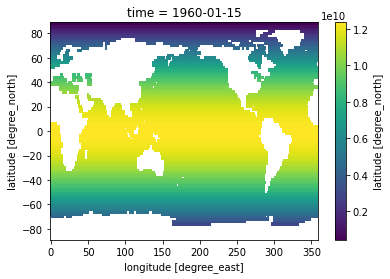

In [21]:
pixel_area = dA.where(sst[0].notnull())
pixel_area.plot()

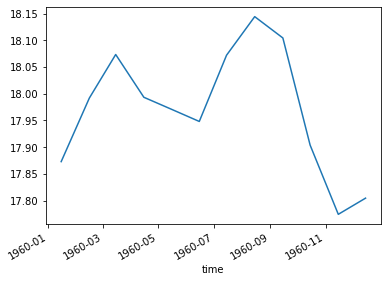

In [22]:
total_ocean_area = pixel_area.sum(dim=('lon', 'lat'))
sst_weighted_mean = (sst * pixel_area).sum(dim=('lon', 'lat')) / total_ocean_area
sst_weighted_mean.plot()

xarray 还可以一次性打开多个 文件, 写入一个dataset. 使用 open_mfdataset 函数即可.

In [23]:
ds_all = xr.open_mfdataset('./tutorial-data/sst/*nc', combine='by_coords')
ds_all

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(12, 89, 180), meta=np.ndarray>
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

现在57年的数据都在其中.

接着尝试一些运算, 先看看 groupby

In [24]:
sst_clim = ds_all.sst.groupby('time.month').mean(dim='time')
sst_clim

<xarray.DataArray 'sst' (month: 12, lat: 89, lon: 180)>
dask.array<stack, shape=(12, 89, 180), dtype=float32, chunksize=(1, 89, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

可以看到, 一个Array由多个chunk 一起组成, 这样便于并行处理. 实际上使用 open_mfdataset 一次性打开多个数据文件时, xarray默认将每个netcdf文件chunk到一个Dask array, 在后面使用Dask的时候会有更多介绍.

经过 groupby后, time维度变为month

## 注意事项

这一小节积累一些日常使用的注意事项, 日常更新...

### DataArray乘法

对 xarray 中 DataArray做计算时, 默认的是按照维度名字匹配的, 看下面的例子.

In [10]:
import xarray as xr
x = xr.DataArray(
     [[1.0, 2.0], [3.0, 5.0]],
     dims=("lat", "lon"),
     coords={"lat": [35.0, 40.0], "lon": [100.0, 120.0]},
     name="var1",
)
x

<xarray.DataArray 'var1' (lat: 2, lon: 2)>
array([[1., 2.],
       [3., 5.]])
Coordinates:
  * lat      (lat) float64 35.0 40.0
  * lon      (lon) float64 100.0 120.0

In [11]:
t = xr.DataArray([0.1,0.2,0.3], dims="time", coords={"time": [1, 2, 3]}, name="var2")
t

<xarray.DataArray 'var2' (time: 3)>
array([0.1, 0.2, 0.3])
Coordinates:
  * time     (time) int32 1 2 3

In [14]:
y = x * t
y

<xarray.DataArray (lat: 2, lon: 2, time: 3)>
array([[[0.1, 0.2, 0.3],
        [0.2, 0.4, 0.6]],

       [[0.3, 0.6, 0.9],
        [0.5, 1. , 1.5]]])
Coordinates:
  * lat      (lat) float64 35.0 40.0
  * lon      (lon) float64 100.0 120.0
  * time     (time) int32 1 2 3

可以看到上述计算中, 乘积是执行的笛卡尔积, 因为没有维度对应上. 再看一个例子

In [15]:
z = x * y
z

<xarray.DataArray (lat: 2, lon: 2, time: 3)>
array([[[0.1, 0.2, 0.3],
        [0.4, 0.8, 1.2]],

       [[0.9, 1.8, 2.7],
        [2.5, 5. , 7.5]]])
Coordinates:
  * lat      (lat) float64 35.0 40.0
  * lon      (lon) float64 100.0 120.0
  * time     (time) int32 1 2 3

In [16]:
x

<xarray.DataArray 'var1' (lat: 2, lon: 2)>
array([[1., 2.],
       [3., 5.]])
Coordinates:
  * lat      (lat) float64 35.0 40.0
  * lon      (lon) float64 100.0 120.0

可以看到, lat和lon一致的地方对应相乘; 关于时间维, 相当于在x上执行了广播运算. 也就是说相当于 x * y.isel(time=0),  x * y.isel(time=1),  x * y.isel(time=2)

In [21]:
x * y.isel(time=0)

<xarray.DataArray (lat: 2, lon: 2)>
array([[0.1, 0.4],
       [0.9, 2.5]])
Coordinates:
  * lat      (lat) float64 35.0 40.0
  * lon      (lon) float64 100.0 120.0
    time     int32 1